<a href="https://colab.research.google.com/github/thishaniwijayaratne/Radar_Assignments/blob/master/170698J_Radar_Assignment_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EN4353 - Radar and Navigation - Assignment 02
## 170698J - L.T.A WIjayaratne


## Introduction

The code below lays out the methodology for seperating targets and clouds from noise using a Radar signal. 

The following 10 steps were followed.



1.   Down-sampling the raw signal data
2.   Calculating the **Average Noise** and **Threshold values** for each bin 
3.   Identifying targets and seperating cloud & noise clutter
4.   Repeatedly applying **Outlier Removal** filters to remove outliers, and **Spike Removal** smoothen the conturs of detected clouds. 
5.   Filling the gaps in the countours by identifying gap patterns of 1-cell and 2-cells
6.   Re-applying filters as necessary 
7.   Filling the centers of the contours 
8.   Applying Noise/outlier filters
9.   Combining target and cloud matrices
10.  Calculating Range and Azimuth of targets



***
## Importing Dependencies

The Python libraries needed to run the code are imported below. 
***

In [108]:
# Importing necessary libraries
import pandas as pd
import cmath
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
cycol = cycle('brmckg')

***
## Steps to add a custom .csv file


1.   Upload the .csv file to your Google Drive
2.   Obtain the path to the .csv file in your Drive and update the *path* variable below [(example video)](https://www.youtube.com/watch?v=woHxvbBLarQ)
3. Run the code snippet below and authorize colab to use Google Drive
***

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

imaginary_compoent = '/content/drive/MyDrive/Sem_8/Radar/02/imag_component.csv'
real_compoent = '/content/drive/MyDrive/Sem_8/Radar/02/real_component.csv'

In [2]:
# Importing csv files from Google Drive
imaginary_df = pd.read_csv(imaginary_compoent,sep=';',header=None,squeeze=True)
real_df = pd.read_csv(real_compoent,sep=';',header=None,squeeze=True)

# Formatting dataframes in to Numpy arrays
real_data = np.array( list(real_df) )
imaginary_data = np.array( list(imaginary_df) )

***
## Add the Initialization Parameters here



1.   ***raw_sampling_rate:*** Raw video is sampled at the rate of 1080 kHz
2.   ***C:*** The number of range slots ($30$ bins).
3.   ***pulse_repetition_frequency:*** Pulses are sent to the sky at 1800 Hz frequency
4.   ***horizontal_beam_width:*** Horizontal beam width (2°)
5.   ***radar_rotation_speed:*** Rotation speed of the antenna 12 RPM
6.   ***speed_of_RF:*** The speed of RF waves in free sapce $3 \times 10^8$.
7.   ***radar_frequency:*** Frequency of the radar signal $720 MHz$. 
8.   ***N:*** The number of pulses transmitted.



9.   ***object_info:*** A python dictionary containing information regarding the different types of objects to be identified, their velocities, signal thresholds, and values to be used in encoding
***

In [126]:
# Defining Parameters
raw_sampling_rate = 1080000 # Hz
C = 30  # Number of Range slots
pulse_repetition_frequency = 1800  # Hz
horizontal_beam_width = 2 #degrees
radar_rotation_speed = 12 # RPM
speed_of_RF = 3*(10**8) # m/s
radar_frequency = 720000000 #Hz

N = int(len(real_df)/C)


object_info = {'No object':      {'Velocity': None, 'Threshold': None,'Encode': 0},
               'Cloud Clutter':  {'Velocity': 50, 'Threshold': 1.05,'Encode': 1},
               'Ground Clutter': {'Velocity': 0, 'Threshold': None,'Encode': 2},
               'Rain Clutter':   {'Velocity': 20, 'Threshold': 0.9,'Encode': 3},
               'Birds':          {'Velocity': 35, 'Threshold': 1.05,'Encode': 4},
               'Air-crafts':     {'Velocity': 150, 'Threshold': 0.5,'Encode': 5}}


***
## Functions used to Visualize the Radar Signal Data



1.   ***Get_Heat_Map*** (Matrix, Title)

>This function is used to plot the Heatmap of a single data array

- **Matrix:** An array of data values to be plotted in the heatmap.
- **Title:** Title of the heatmap.

2.   ***Subplot_two_Heatmaps*** (Matrix1, Matrix2, Annotate1, Annotate2, Main_Title, Title1, Title2):

>This function is used to the Heatmaps of two data arrays side by side

- ***Matrix1:*** Matrix for the first heatmap.
- ***Matrix2:*** Matrix for the second heatmap.
- ***Annotate1:*** Whether the first heatmaps hould be anotated with cell values.
- ***Annotate2:*** Whether the second heatmap should be anotated with cell values.
- ***Main_Title:*** Main title of the plot. 
- ***Title1:*** Title of the first heatmap.
- ***Title2:*** Title of the second heatmap.

3.   ***Simple_plot(Matrix, Title, x_title, y_title, figure_size)***


***

In [128]:
# Function used to plot the Heatmap of a single data array
def Get_Heat_Map(Matrix, Title):
    f, ax = plt.subplots(figsize=(9,9))
    plt.title(Title,fontsize = 16)
    ax = sns.heatmap(Matrix,annot=False,cmap="YlGnBu")
    ax=ax.set( xlabel="Fast Time", ylabel="Slow Time")
    plt.show()
    print()

# Function used to the Heatmaps of two data arrays side by side
def Subplot_two_Heatmaps(Matrix1, Matrix2, Annotate1, Annotate2, Main_Title, Title1, Title2):
  fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, figsize=(20,9))
  fig.suptitle(Main_Title,fontsize = 25)
  sns.heatmap(Matrix1,annot=Annotate1,cmap="YlGnBu", ax = ax1)
  sns.heatmap(Matrix2,annot=Annotate2,cmap="YlGnBu", ax = ax2)
  ax1.set_title(Title1,fontsize = 16)
  ax2.set_title(Title2,fontsize = 16)  
  ax1 = ax1.set( xlabel="Fast Time", ylabel="Slow Time")
  ax2 = ax2.set( xlabel="Fast Time", ylabel="Slow Time")
  plt.show()
  print()

def Simple_plot(Matrix, Title, x_title, y_title, figure_size):
  plt.figure(figsize = figure_size)
  ax=plt.plot(Matrix)
  ax=plt.ylabel(str(y_title))
  ax=plt.xlabel(str(x_title))
  ax=plt.title(str(Title))
  plt.show()
  print()

***
## **Plotting the Real and Imaginary Components of the Signal Separately**
***

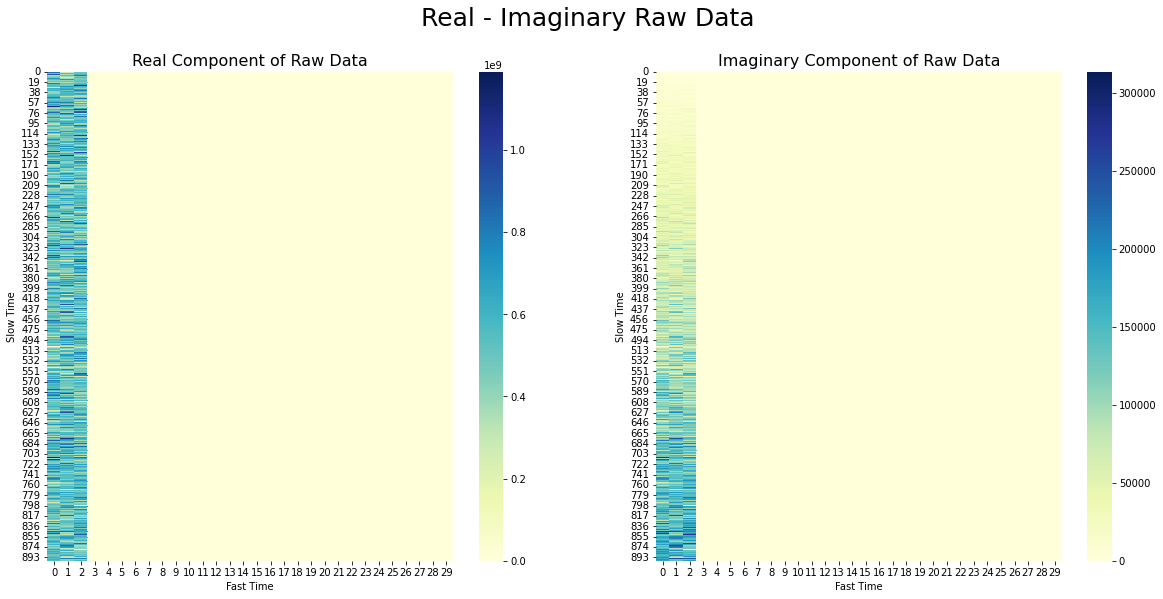

In [129]:
# Reshaping the data matrices 
real_data_matrix = real_data.reshape((N, C))
imaginary_data_matrix = imaginary_data.reshape((N, C))

Subplot_two_Heatmaps(real_data_matrix, imaginary_data_matrix, False, False, "Real - Imaginary Raw Data", "Real Component of Raw Data", "Imaginary Component of Raw Data")


***
## **Plotting the Magnitude and Phase of the Complex Signal**

### The complex signal can be represented as follows
> $C[n] = I[n] + jQ[n]$

### The Magnitude of $C[n]$
> $ |C[n]| = \sqrt[]{I[n]^2 + Q[n]^2}$
### This can be computed using the ***np.abs()*** function.

### Phase of $C[n]$
>$ Θ = \tan ^{-1} \left( \frac{Q[n]}{I[n]} \right)$
### This can be computed using the ***cmath.phase()*** function.


***

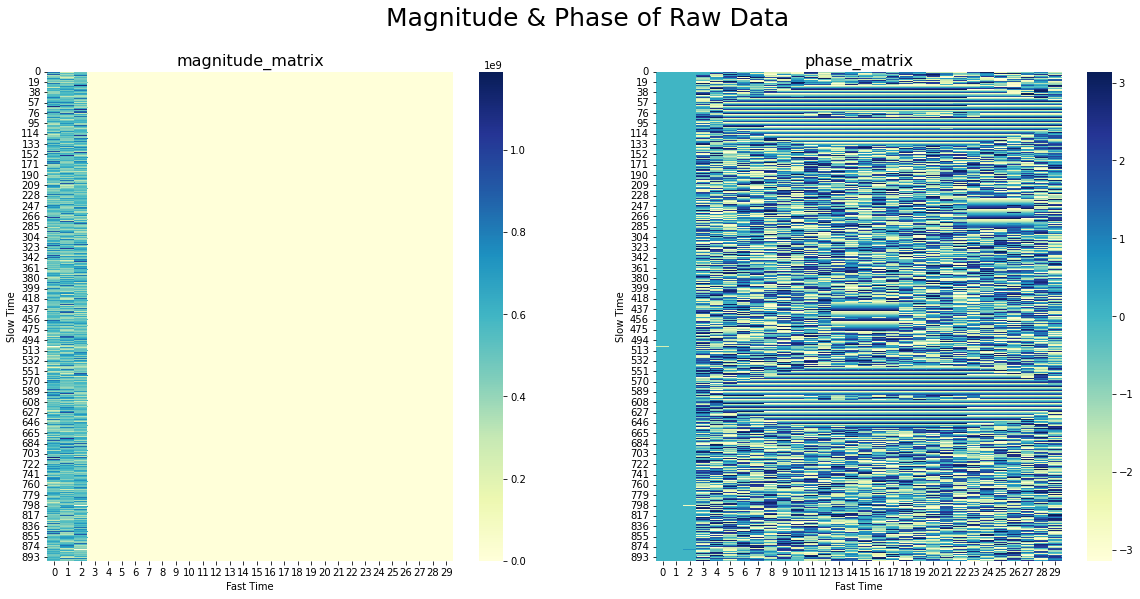

In [130]:
# Creating the complex matrix
C_n = real_data_matrix + 1j * imaginary_data_matrix

# Getting the phase and magnitude of the signal
# Magnitude
magnitude_matrix = np.sqrt(np.square(real_data_matrix) + np.square(imaginary_data_matrix))
# Phase
get_phase = np.vectorize(lambda x: cmath.phase(x))
phase_matrix = get_phase(C_n)

# Plotting the Magnitude and Phase
Subplot_two_Heatmaps(magnitude_matrix, phase_matrix, False, False, "Magnitude & Phase of Raw Data", "magnitude_matrix", "phase_matrix")

***
## **Observations**
#### As seen in the above plots, the first 3 bins have amplitude and phase values that significantly differ from that of the remaining bins.


#### **1.   Very High Amplitude Values**

Ground clutter is generated by radar signals reflected by the ground that is nearest to the radar transmitted. Hence, the amplitude of ground clutter is abnormally high compared to that  

#### **2.   Near Zero phase Values**

***

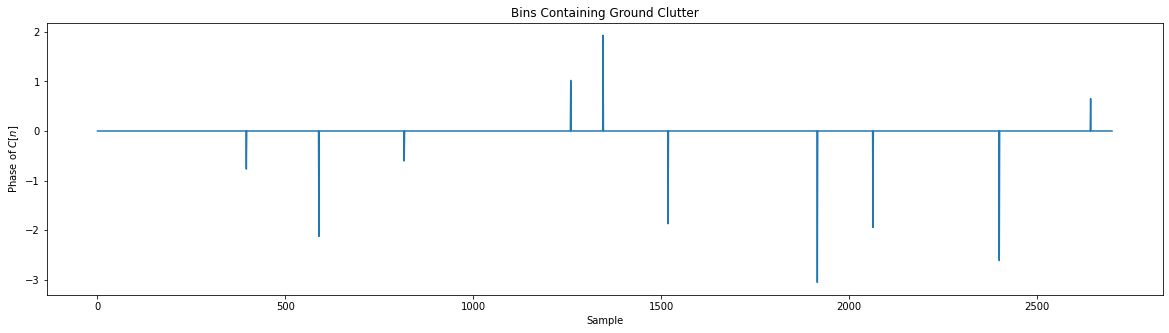

In [113]:
#Plotting the Phase of the first 3 bins of the Radar Signal
Ground_clutter_phase = phase_matrix[:,0:3].flatten()

Simple_plot(Ground_clutter_phase, 
            'Bins Containing Ground Clutter', 
            'Sample', 
            'Phase of $C[n]$', 
            (20, 5))

### As derived in Question $(1)$

$\theta(t) = 2 π f_d T_s (20n + 9)$ 

### When there are non-moving objects (zero velocity) in a particular cell in the matrix;

$f_{d} → 0 $

$⇒ 2 π f_d T_s (20n + 9) → 0$

$⇒ \theta(t) → 0$

### $\therefore$ when implementing the zero velocity filter, we can identify cells where the phase of the complex number are 

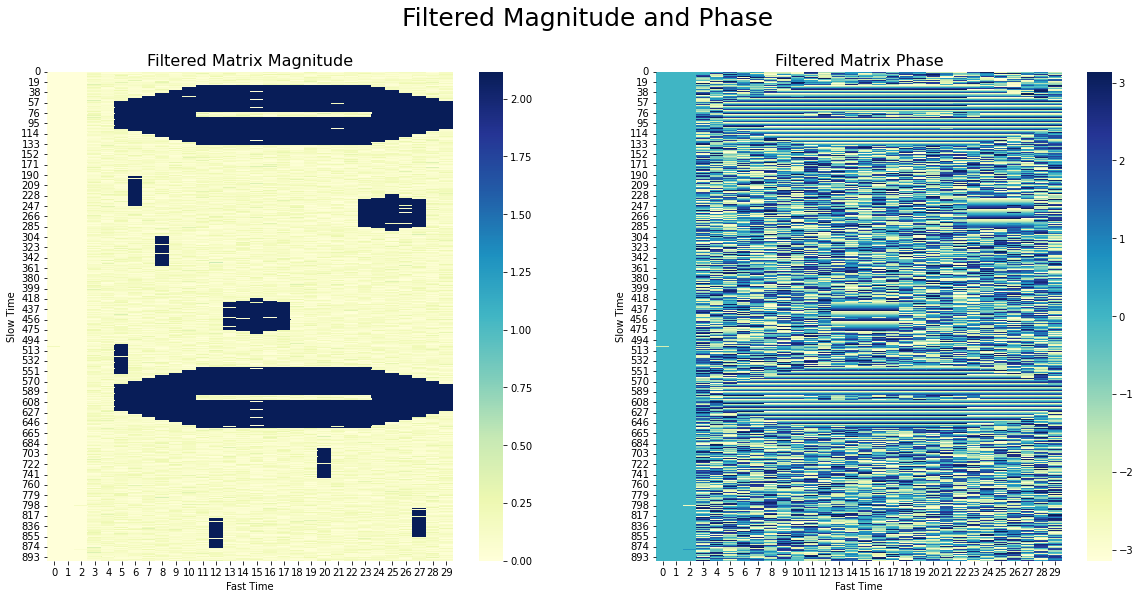

In [183]:
def Zero_Velocity_Filter(C_n,phase_matrix, threshold, object_info):
  # Replacing cells with zero velocity zero
  Filtered_Matrix = np.where(np.abs(phase_matrix) < threshold ,0, C_n)

  # Generating a sepate matrix with only the ground clutter cells encoded
  Encoded_Matrix = np.where(np.abs(phase_matrix) < threshold ,object_info['Ground Clutter']['Encode'], 0)
  return Filtered_Matrix,Encoded_Matrix

threshold = 10e-4
Zero_Velocity_Filtered_Matrix, Zero_Velocity_Encoded_Matrix = Zero_Velocity_Filter(C_n,phase_matrix, threshold, object_info)

Subplot_two_Heatmaps(np.abs(Zero_Velocity_Filtered_Matrix), get_phase(Zero_Velocity_Filtered_Matrix), False, False, "Filtered Magnitude and Phase", "Filtered Matrix Magnitude", "Filtered Matrix Phase")


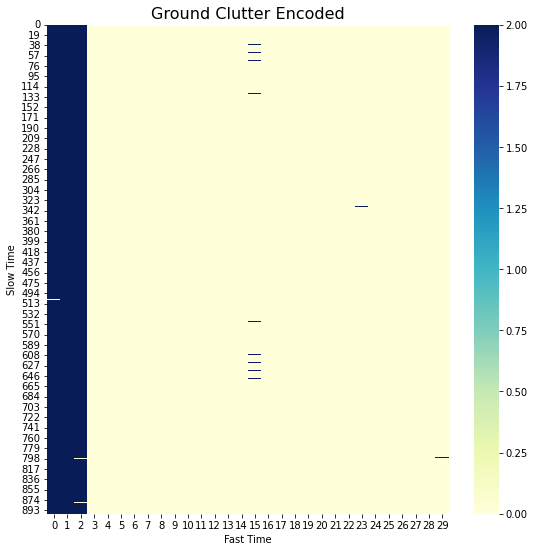

In [184]:
# Plotting the Matrix of fixed targets (Mainly consisting of ground clutter)
Get_Heat_Map(Zero_Velocity_Encoded_Matrix, "Ground Clutter Encoded")

***
<!-- $\href{https://www.youtube.com/watch?v=O0Y8FChBaFU}{Good Reference For Plotting DFT}$ -->

## **Computing DFT of $C[n]$**

***

In [185]:
#Get DFT of Datamatrix(ground clutter filtered)
FFT_Matrix = np.fft.fft(Zero_Velocity_Filtered_Matrix, axis=0)


***
## **Plotting the DFT**


***

In [186]:
def plot_DFT( FFT_Matrix,
              Object_velocities,
              F_s,
              title,
              is_lines,
              single_bin = 0,
             figure_size = (30, 8)):
  absolute_freq = np.abs(FFT_Matrix)
  N = len(FFT_Matrix)

  # Plot the positive frequencies.
  f_pos = np.arange(0, F_s / 2, step=F_s / N)

  plt.figure(figsize = figure_size)
  ax=plt.ylabel('Magnitude of Frequecy Components')
  ax=plt.xlabel('Frequency (Hz)')
  ax=plt.title(str(title))
  ax = plt.xticks(np.arange(-F_s/2,F_s / 2,(F_s*30)/N))

  if single_bin:
    col0 = next(cycol)
  else:
    col0=None
  plt.plot(f_pos, absolute_freq[:(N // 2)],color=col0)

  # print('Range of freqs:', f_pos.shape)

  for objects,frq in Object_velocities.items():
    
    col = next(cycol)
    if is_lines:
      if frq!=None:
        plt.vlines(x=frq,ymin=0,ymax=max(absolute_freq.flatten())+50,linestyles='--',colors=col,label=objects)
  
  handles, labels = plt.gca().get_legend_handles_labels() 
  labels, ids = np.unique(labels, return_index=True)
  handles = [handles[i] for i in ids]
  plt.legend(handles, labels, loc='best')
  plt.show()
  print()
  return None

***
## **Computing Dopplar Shifts for Object Classes**

## $f_d =  \frac{2 V_r}{λ} $
## $f_d = \frac{2 V_r}{ \left( \frac{c}{f_{radar}} \right) }$

***

In [187]:
#Calculating frequency values for object categories
Object_velocities = {}

for objects,info in object_info.items():
  Object_velocity = info['Velocity']
  if Object_velocity!= None:
    dopl_freq = (2*Object_velocity/(speed_of_RF/radar_frequency))
    Object_velocities[objects] = dopl_freq
  else:
    Object_velocities[objects] = None

# print(Object_velocities)

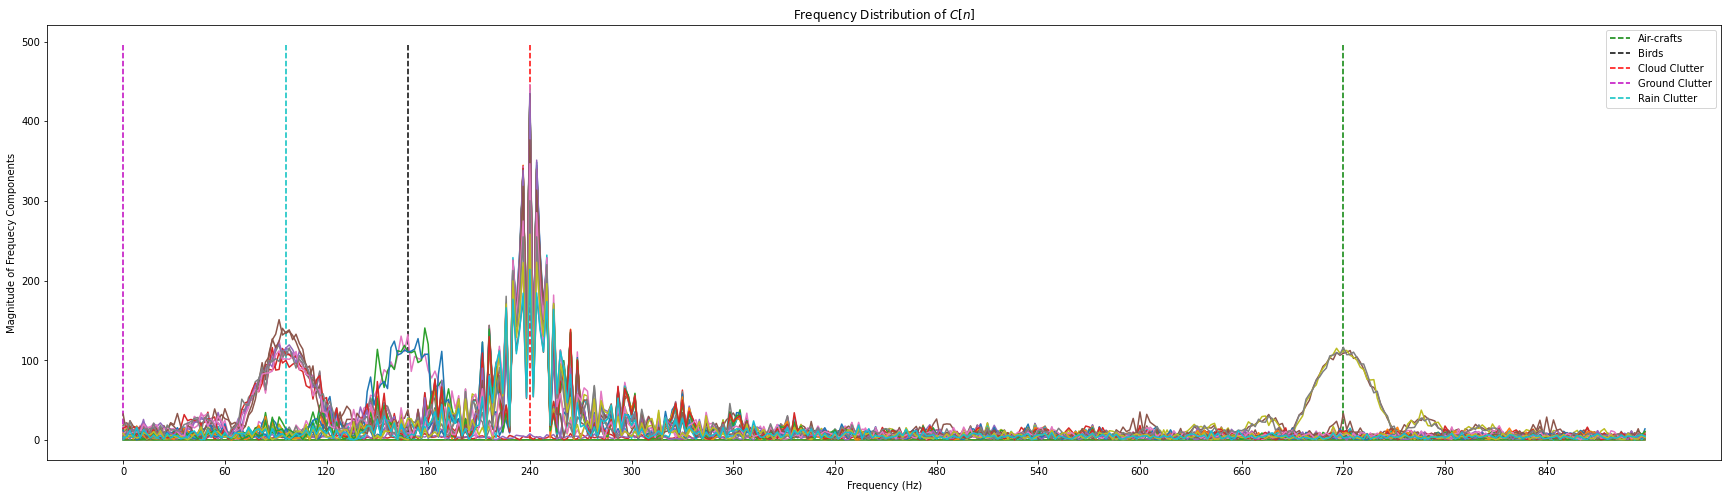

In [188]:
plot_DFT(FFT_Matrix,
         Object_velocities,
         pulse_repetition_frequency,
         'Frequency Distribution of $C[n]$',
         1,
         0)




`$\href{https://www.geeksforgeeks.org/design-an-iir-notch-filter-to-denoise-signal-using-python/}{implementing notch filter}$

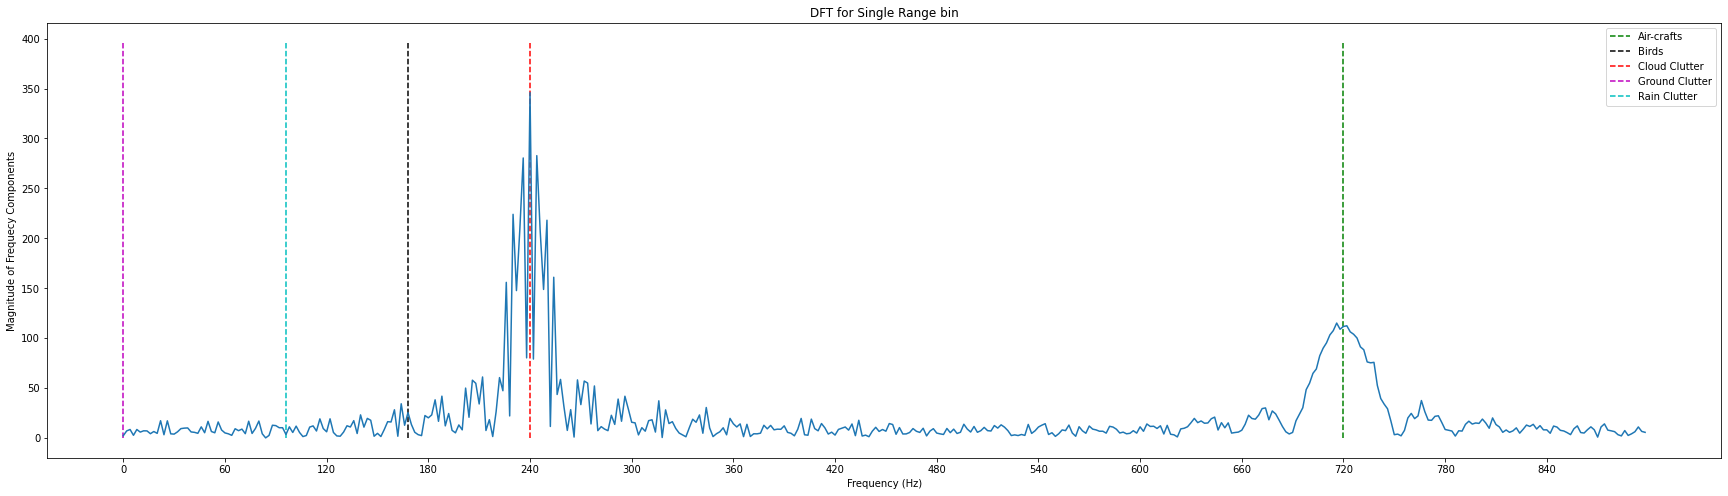

In [189]:
#get FFt for single range bin 
plot_DFT(FFT_Matrix[:,8],
         Object_velocities,
         pulse_repetition_frequency,
         'DFT for Single Range bin',
         1)

***

## By observation determining the 

***


In [190]:
#Bandwidth in Hz
filter_bandwidth = 36

***

## Implementing a Custom Band-pass Filter

### The following ***Band_pass_filter()*** function 

***

In [191]:
def Band_pass_filter(Lower_cutoff,
                     Higher_cutoff,
                     fs,
                     N,
                     is_plot):
  
  filter_frequency = np.arange(0, fs, step=fs / N)
  filter_vals = 1. * ((filter_frequency >= Lower_cutoff) & (filter_frequency <= Higher_cutoff))
  filter_vals = filter_vals.reshape(filter_vals.shape[0], 1)
  
  if is_plot:
    plt.plot(filter_vals)
  return filter_vals  


 Cloud Clutter filter with cut off frequencies: 204.0 - 276.0 Hz



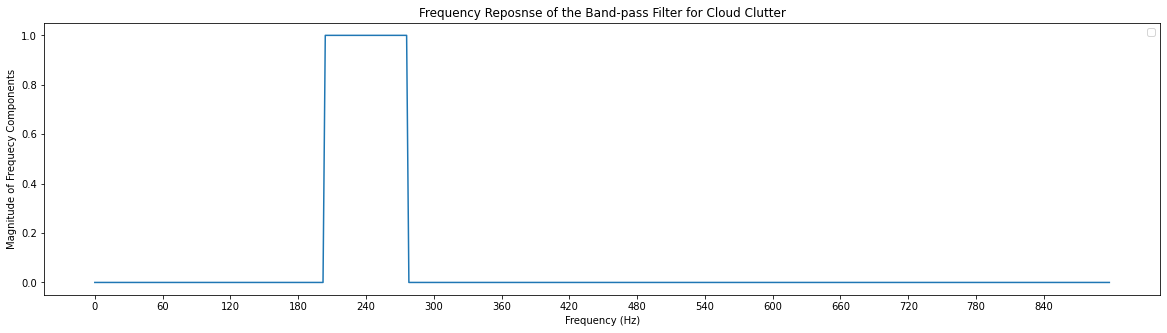

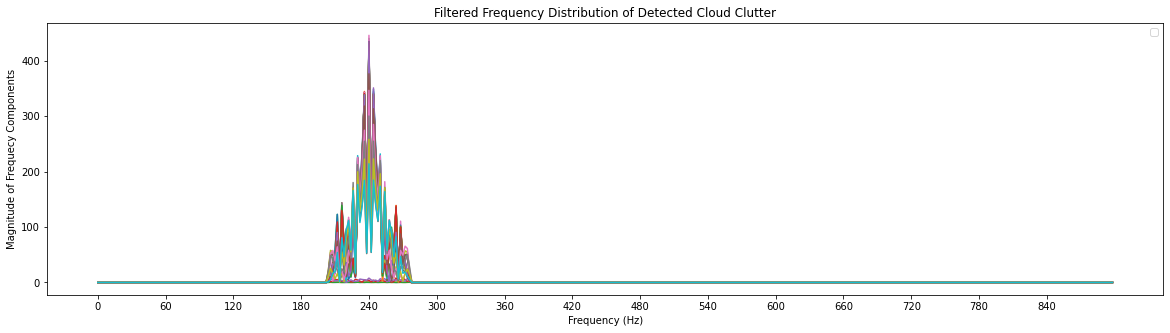



 Rain Clutter filter with cut off frequencies: 60.0 - 132.0 Hz



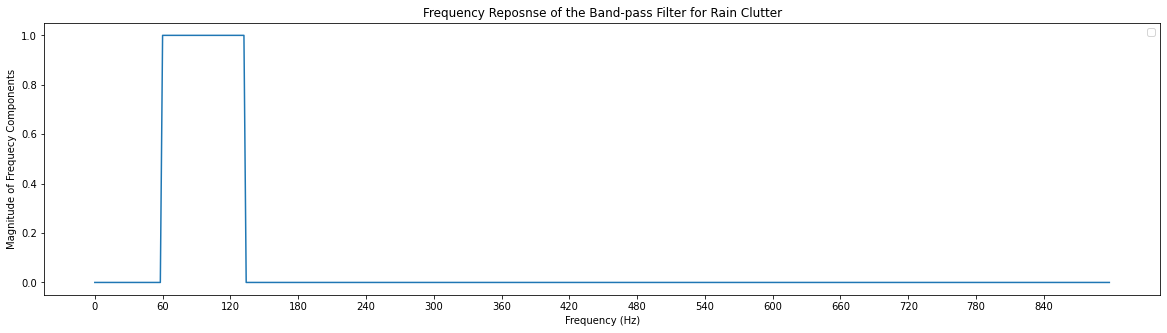

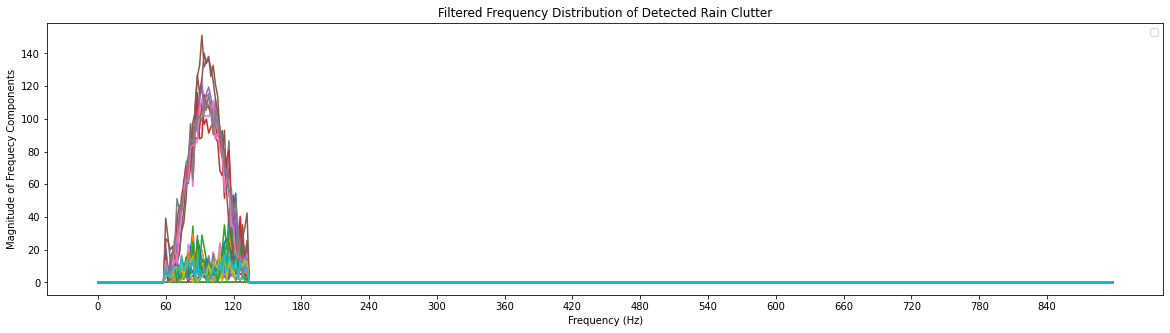



 Birds filter with cut off frequencies: 132.0 - 204.0 Hz



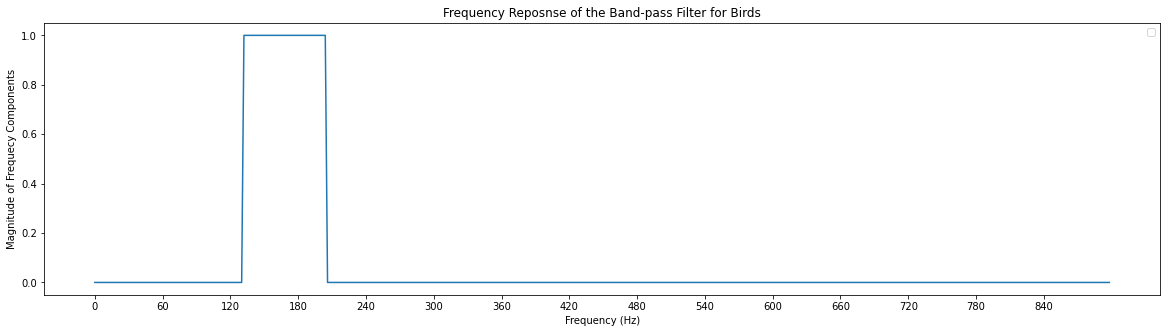

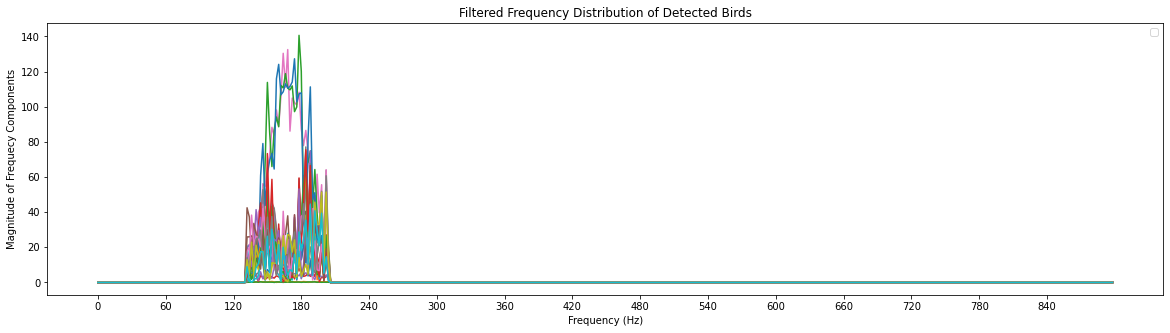



 Air-crafts filter with cut off frequencies: 684.0 - 756.0 Hz



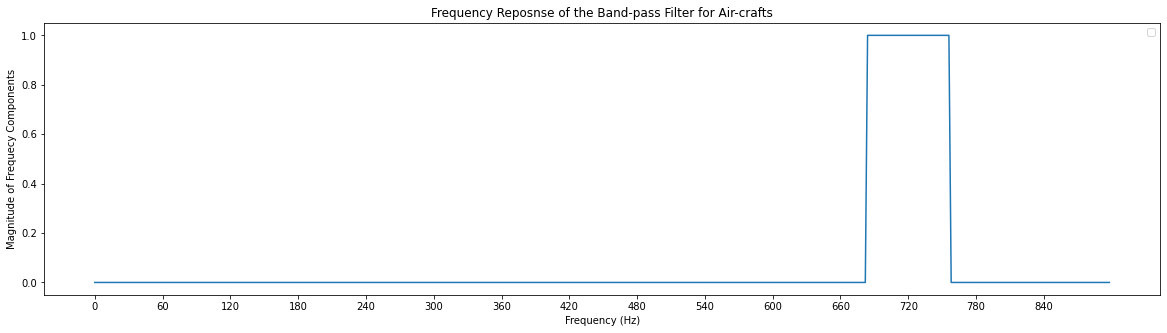

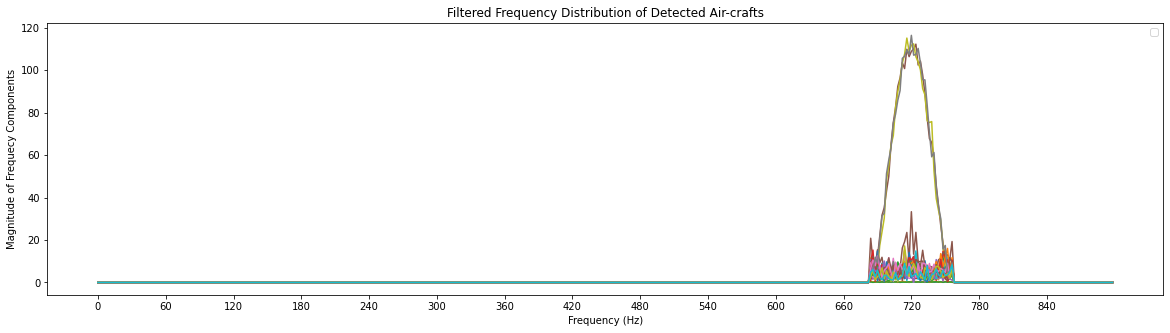

In [192]:
#Implement Doppler Filter Bank

dict_final = {}


object_info = {'No object':      {'Velocity': None, 'Threshold': None,'Encode': 0},
               'Cloud Clutter':  {'Velocity': 50, 'Threshold': 1.05,'Encode': 1},
               'Ground Clutter': {'Velocity': 0, 'Threshold': None,'Encode': 2},
               'Rain Clutter':   {'Velocity': 20, 'Threshold': 0.9,'Encode': 3},
               'Birds':          {'Velocity': 35, 'Threshold': 1.05,'Encode': 4},
               'Air-crafts':     {'Velocity': 150, 'Threshold': 0.5,'Encode': 5}}


# Considering the Object categories and their respective speeds
for objects,info in Object_velocities.items():

  if ((info != None) and (info != 0)):
    print('\n',objects, 'filter with cut off frequencies:', (info - filter_bandwidth), "-", (info + filter_bandwidth),'Hz\n')

    # Generating Band-pass filter Frequency Response for each Object class
    filter_response = Band_pass_filter((info - filter_bandwidth),
                             (info + filter_bandwidth),
                             pulse_repetition_frequency,
                             N,
                             0)
    
    # Plotting the frequency reposnse of the filter
    plot_DFT(filter_response,
             Object_velocities,
             pulse_repetition_frequency,
             'Frequency Reposnse of the Band-pass Filter for ' + objects,
             0,
             0,
             (20,5))
    
    # Multiplying the DFT of the signal with the Frequency Response of the Band-pass filter  
    filtered_DFT_matrix = np.multiply(FFT_Matrix[:,:],filter_response)
    
    # Plotting the frequency reposnse of the filter
    plot_DFT(filtered_DFT_matrix,
             Object_velocities,
             pulse_repetition_frequency,
             'Filtered Frequency Distribution of Detected ' + objects,
             0,
             0,
             (20,5))
    
    # Obtaining Inverse DFT of the filtered frequency response
    DM_dopl_filt = np.fft.ifft(filtered_DFT_matrix[:,:],axis=0)
    
    #Applying the threshold values and encoding each object category
    threshold = object_info[objects]['Threshold']
    encode = object_info[objects]['Encode']
    DM_final = (abs(DM_dopl_filt)>=threshold)*encode 

    #write final matrix to dict
    dict_final[objects] = [DM_final,filter_response,abs(DM_dopl_filt)] 

    #write final matrix to .csv file
    np.savetxt(objects+".csv", DM_final, delimiter=",")

    

In [193]:
def Heatmap_with_labels(matrix,
                        dict_label,
                        title):
  f,ax = plt.subplots(figsize=(12,10))
  ax.set_title(title)
  vmap = dict_label
  n=len(vmap)
  cmap = sns.color_palette('RdBu', n)
  ax = sns.heatmap(matrix, cmap='RdBu')

  # Get the colorbar object from the Seaborn heatmap
  colorbar = ax.collections[0].colorbar
  # The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
  r = colorbar.vmax - colorbar.vmin
  colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
  colorbar.set_ticklabels(list(vmap.keys()))
  print()

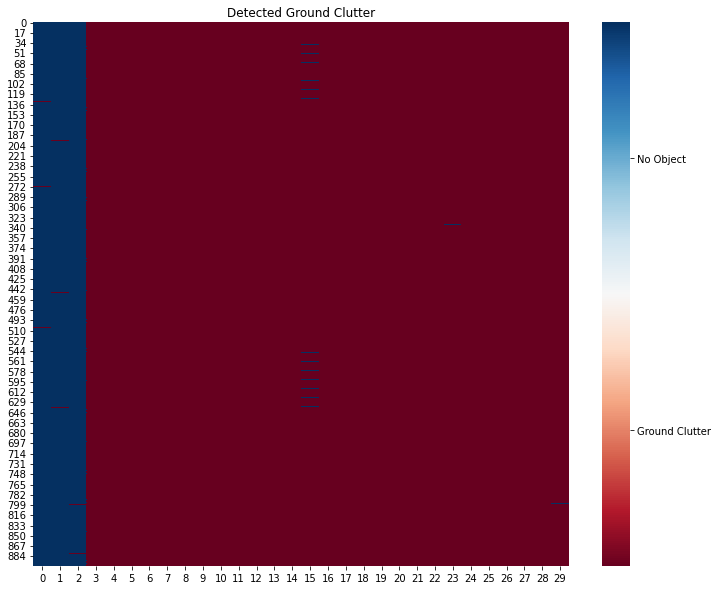

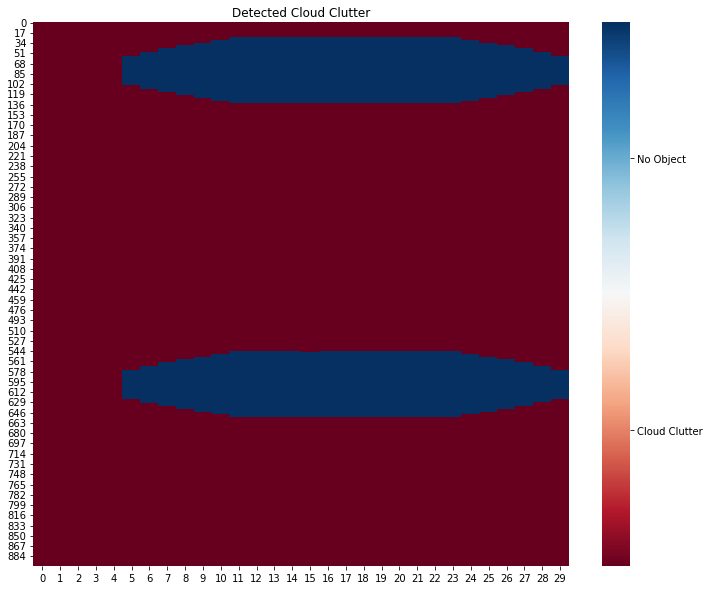

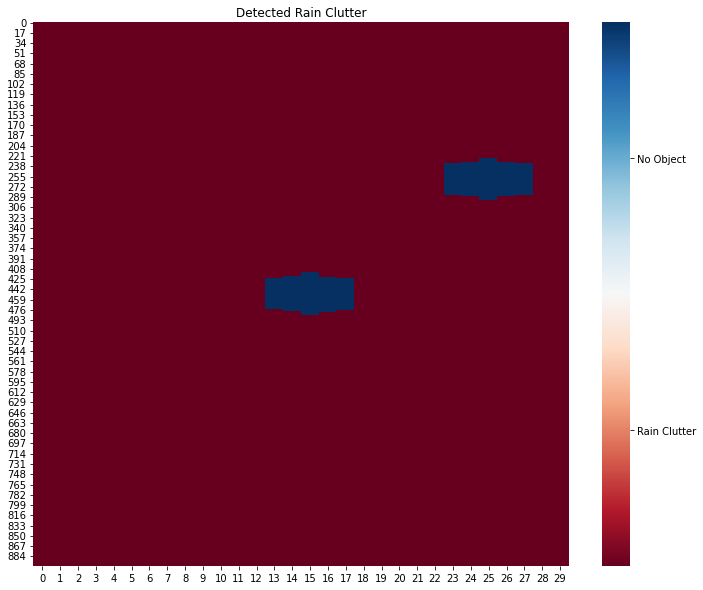

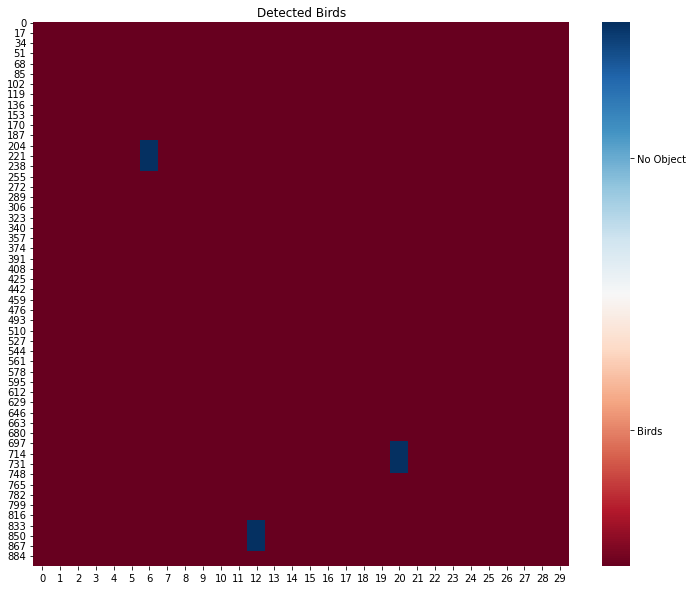

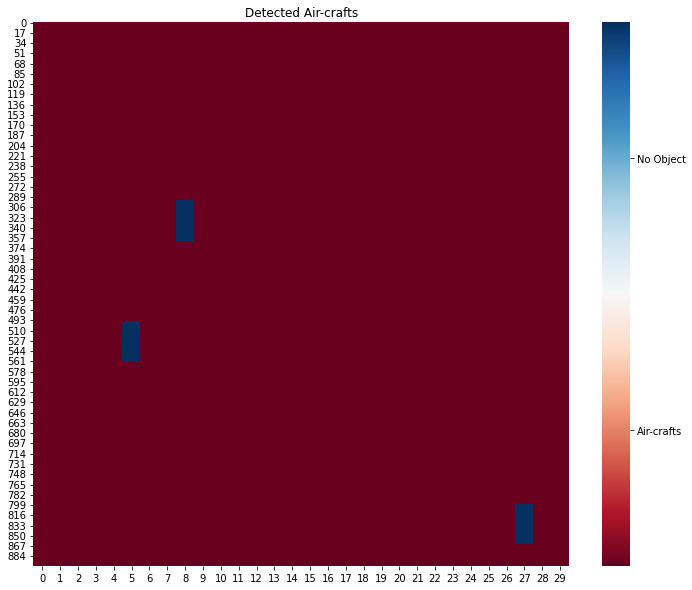

In [194]:
all_DM = Zero_Velocity_Encoded_Matrix

# px= Heatmap_with_labels(Zero_Velocity_Encoded_Matrix,
#                  {'Ground Clutter':1, 'No Object':0},
#                  'Detected Ground Clutter')
# np.savetxt("Ground Clutter.csv", Zero_Velocity_Encoded_Matrix, delimiter=",") #save GC

Get_Heat_Map(Zero_Velocity_Encoded_Matrix, "Ground Clutter Encoded")


for keys,vals in dict_final.items():
  DM_plot = vals[0]
  all_DM +=DM_plot
  title = 'Detected '+keys
  px = Heatmap_with_labels(DM_plot,
                           {keys:np.max(DM_plot),'No Object':0},
                           title)

